# Example climb: Matching means with maximum structural diversity

## 1. Notebook setup

### 1.1. Imports


In [1]:
import sys
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

sys.path.append('..')

from hill_climber import HillClimber

### 1.2. Run hyperparameters

In [2]:
# Number of input data points
n = 1000

# Run duration in minutes
run_time = 30

# Replica exchange parameters
n_replicas = 16
exchange_interval = 1000
temperature = 1   # T_min for replica exchange
T_max = 1000      # T_max for replica exchange

# Hill climb parameters
step_spread = 0.2
perturb_fraction = 0.001
cooling_rate = 0.00001


### 1.3. Input distributions

Initial statistics:
Mean w: 10.0387
Mean x: 10.1417
Mean y: 10.0117
Mean z: 9.9626

Initial pairwise KS statistics (similarity):
w-x: 0.0450
w-y: 0.0210
w-z: 0.0400
x-y: 0.0470
x-z: 0.0600
y-z: 0.0380


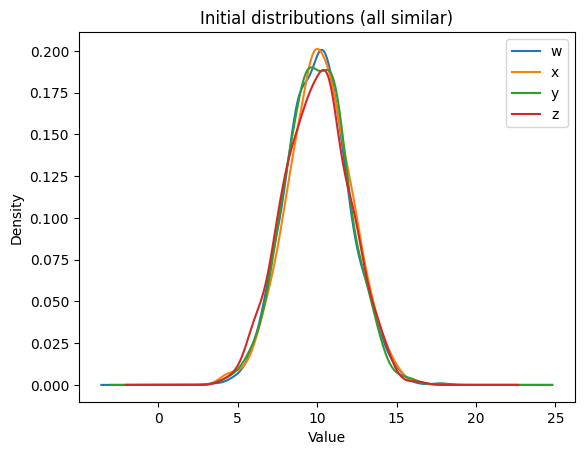

In [3]:
# Create input distributions (4 variables, all strictly positive)
# Start with similar normal distributions that will be evolved into different structures
np.random.seed(42)  # For reproducibility

data = pd.DataFrame({
    'w': np.random.normal(loc=10.0, scale=2.0, size=n),
    'x': np.random.normal(loc=10.0, scale=2.0, size=n),
    'y': np.random.normal(loc=10.0, scale=2.0, size=n),
    'z': np.random.normal(loc=10.0, scale=2.0, size=n)
})

# Ensure all values are strictly positive by clipping any negative values
for col in data.columns:
    data[col] = np.maximum(data[col], 0.1)  # Minimum value of 0.1

print("Initial statistics:")

for col in data.columns:
    print(f"Mean {col}: {np.mean(data[col]):.4f}")

print(f"\nInitial pairwise KS statistics (similarity):")

for col1, col2 in combinations(data.columns, 2):
    ks_stat, _ = stats.ks_2samp(data[col1], data[col2])
    print(f"{col1}-{col2}: {ks_stat:.4f}")

# Visualize using KDE plots to show initial distribution shapes
fig, ax = plt.subplots()

for col in data.columns:
    data[col].plot.kde(label=col, ax=ax)

plt.title('Initial distributions (all similar)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

## 2. Maximize structural diversity while preserving mean similarity

### 2.1. Objective function


In [4]:
def objective_similar_means_diverse_structures(w, x, y, z):
    '''Maximize structural diversity while maintaining similar means.
    
    Objective function: mean_wasserstein_distance - penalty_weight * mean_penalty
    
    This encourages:
        - Similar means across all 4 distributions (w, x, y, z)
        - Maximum structural diversity between distributions (high pairwise Wasserstein distances)
    
    The objective constrains the first moment (mean) while maximizing shape differences.
    Uses Wasserstein distance (Earth Mover's Distance) which is more sensitive to 
    distributional differences throughout the entire range compared to KS statistic.
    
    Args:
        w, x, y, z: Four variables (array-like)
    
    Returns:
        Tuple of (metrics_dict, objective_value) where:
            - metrics_dict: Dict with means, Wasserstein distances, and penalties
            - objective_value: mean_wasserstein_distance - penalty_weight * mean_penalty
    '''
    
    # Calculate means for all 4 distributions
    means = {
        'w': np.mean(w),
        'x': np.mean(x), 
        'y': np.mean(y),
        'z': np.mean(z)
    }
    
    # Calculate standard deviations for visualization
    stds = {
        'w': np.std(w),
        'x': np.std(x),
        'y': np.std(y),
        'z': np.std(z)
    }
    
    # Calculate target mean (average across all distributions)
    target_mean = np.mean(list(means.values()))
    
    # Calculate mean penalty - how far each mean is from the target
    mean_deviations = [abs(mean_val - target_mean) for mean_val in means.values()]
    mean_penalty = np.mean(mean_deviations)
    
    # Calculate pairwise Wasserstein distances to measure structural diversity
    distributions = {'w': w, 'x': x, 'y': y, 'z': z}
    wasserstein_distances = {}
    wasserstein_values = []
    
    for name1, name2 in combinations(distributions.keys(), 2):
        w_dist = stats.wasserstein_distance(distributions[name1], distributions[name2])
        wasserstein_distances[f'Wasserstein_{name1}_{name2}'] = w_dist
        wasserstein_values.append(w_dist)
    
    # Mean Wasserstein distance - higher means more structural diversity
    mean_wasserstein = np.mean(wasserstein_values)
    min_wasserstein = np.min(wasserstein_values)
    max_wasserstein = np.max(wasserstein_values)
    
    # Objective: maximize structural diversity while maintaining similar means
    penalty_weight = 10.0
    objective = mean_wasserstein - (penalty_weight * mean_penalty)
    
    # Compile metrics
    metrics = {
        'Mean W': means['w'],
        'Mean X': means['x'],
        'Mean Y': means['y'],
        'Mean Z': means['z'],
        'Std W': stds['w'],
        'Std X': stds['x'],
        'Std Y': stds['y'],
        'Std Z': stds['z'],
        'Target Mean': target_mean,
        'Mean Penalty': mean_penalty,
        'Mean Wasserstein': mean_wasserstein,
        'Min Wasserstein': min_wasserstein,
        'Max Wasserstein': max_wasserstein,
        **wasserstein_distances
    }
    
    return metrics, objective


### 2.2. Hill climbing run

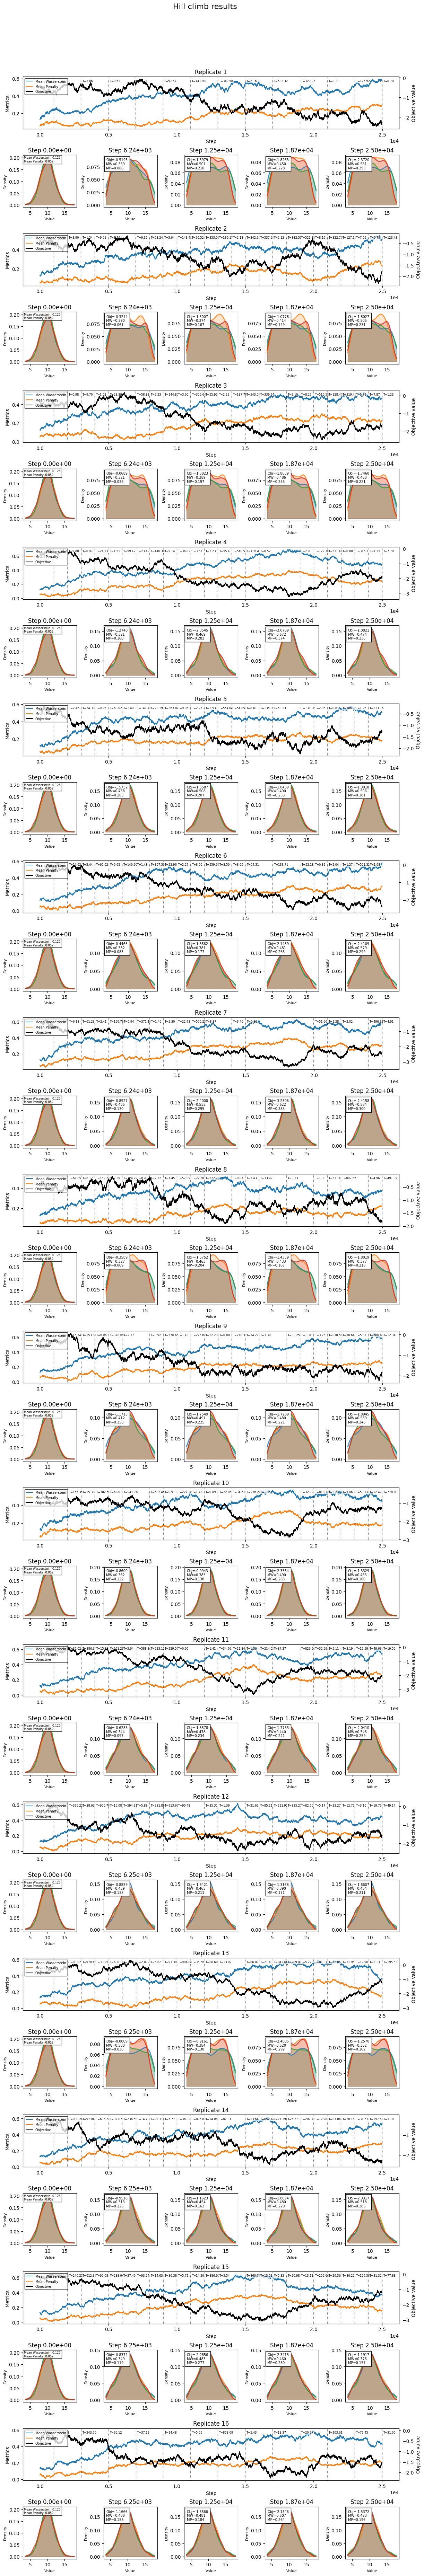

In [5]:
# Create HillClimber instance with replica exchange
climber = HillClimber(
    data=data,
    objective_func=objective_similar_means_diverse_structures,
    max_time=run_time,
    step_spread=step_spread,
    perturb_fraction=perturb_fraction,
    exchange_interval=exchange_interval,
    temperature=temperature,
    T_max=T_max,
    cooling_rate=cooling_rate,
    mode='maximize',
    n_replicas=n_replicas,
    plot_type='histogram',
    plot_metrics=[
        'Mean Wasserstein',
        'Mean Penalty',
    ]
)

# Run optimization with replica exchange
best_data, history_df = climber.climb()

### 2.3. Results

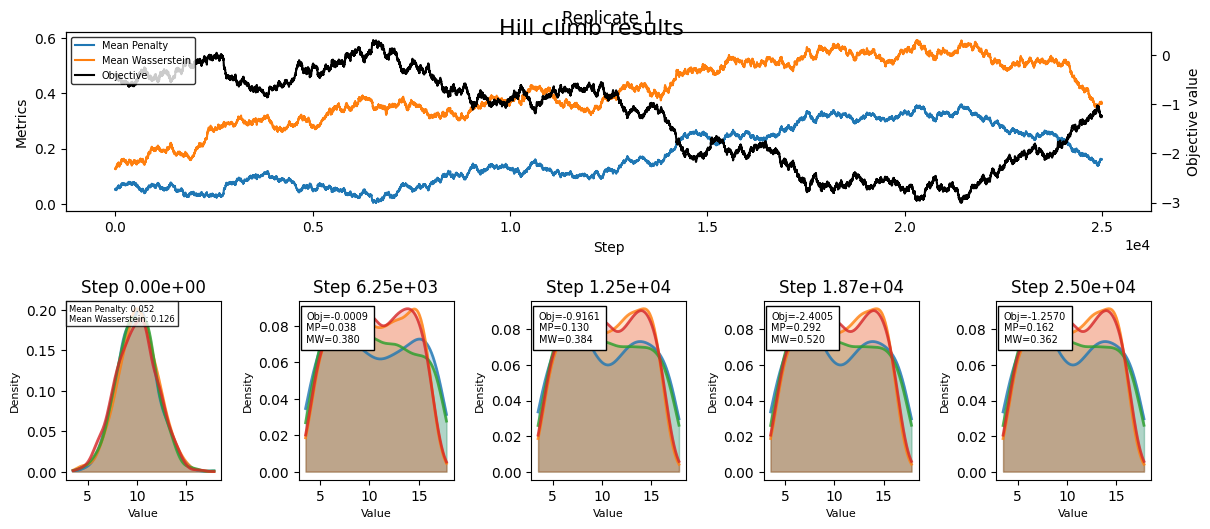

In [6]:
# Display key metrics using histograms
climber.plot_results(
    (best_data, history_df),
    plot_type='histogram', 
    metrics=[
        'Mean Penalty',
        'Mean Wasserstein',
    ]
)


### 2.4. Best result visualization

BEST RESULT VISUALIZATION
Final objective: -1.2570

Final statistics:
  W: mean=10.48, std=4.09
  X: mean=10.49, std=3.53
  Y: mean=10.48, std=3.92
  Z: mean=10.48, std=3.59


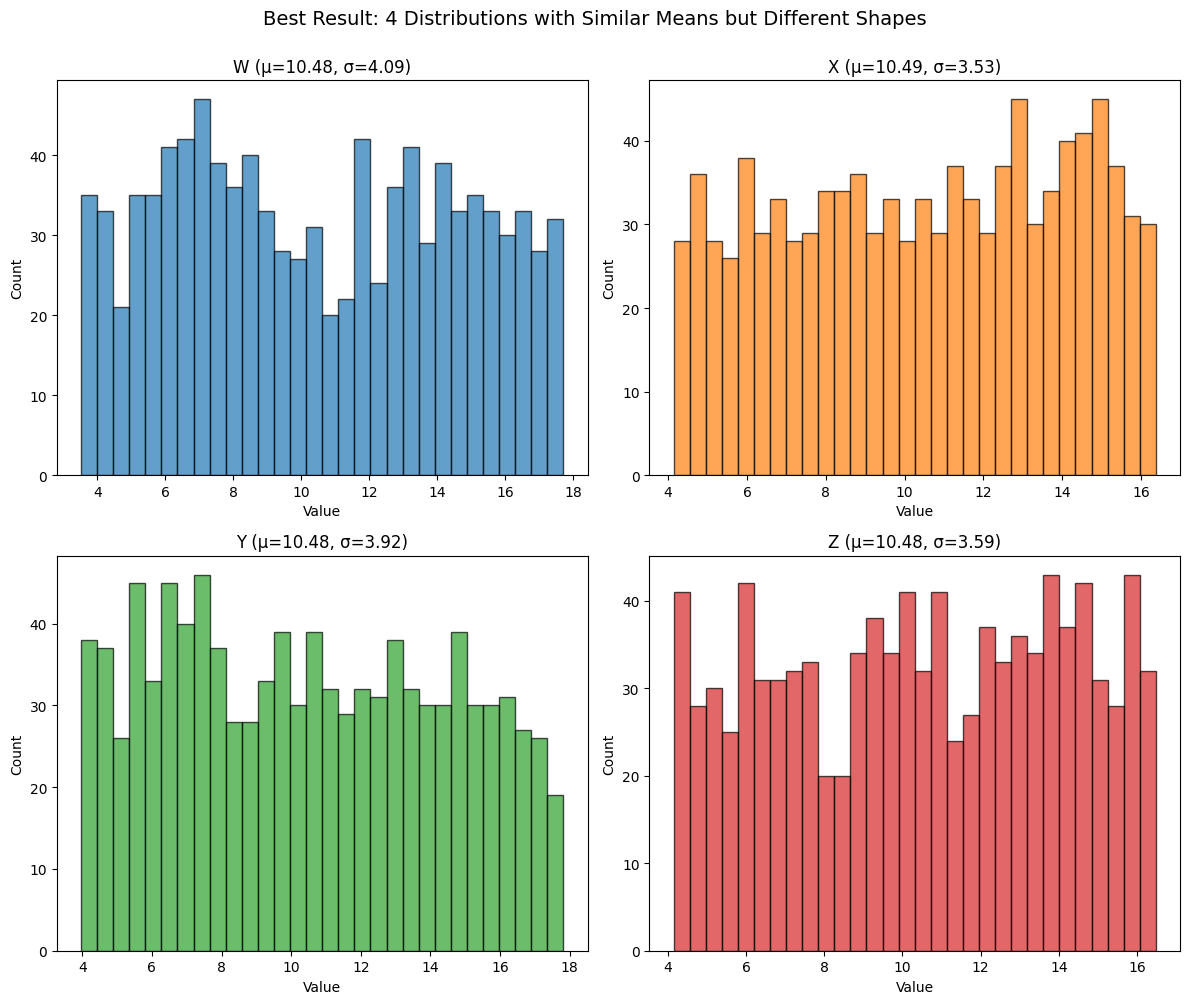

In [7]:
# Visualize the best result's distributions
print("="*60)
print("BEST RESULT VISUALIZATION")
print("="*60)

print(f"Final objective: {history_df['Objective value'].iloc[-1]:.4f}")
print()

# Print final statistics
print("Final statistics:")
for col in best_data.columns:
    print(f"  {col.upper()}: mean={np.mean(best_data[col]):.2f}, std={np.std(best_data[col]):.2f}")

# Plot individual histograms for each distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, col in enumerate(best_data.columns):
    ax = axes[i]
    ax.hist(best_data[col], bins=30, color=colors[i], edgecolor='black', alpha=0.7)
    ax.set_title(f'{col.upper()} (μ={np.mean(best_data[col]):.2f}, σ={np.std(best_data[col]):.2f})', 
                 fontsize=12)
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')

fig.suptitle('Best Result: 4 Distributions with Similar Means but Different Shapes', 
             fontsize=14, y=1.00)
plt.tight_layout()
plt.show()
